In [1]:
import sys, os
sys.path.append(os.path.abspath("."))
sys.path.append(os.path.abspath(".."))
from yahoo_data.services.get_ta_indicators import GenerateTechnicalIndicators
from yahoo_data.services.get_pca import GeneratePCAByGrouping
from data_analysis.useful_defaults import GROUPS
technical_indicators_petr4_df = GenerateTechnicalIndicators(
    'PETR4.SA',
    '2015-01-01',
    '2020-01-01'
).run_with_default_params()
technical_indicators_petr4_df = technical_indicators_petr4_df.dropna()
from yahoo_data.services.get_pca import GeneratePCAByGrouping

groups = GROUPS

from data_analysis.services.stock_preprocessor import StockPreprocessor

petr4_1_days = StockPreprocessor.preprocess(
    'PETR4.SA',
    '2015-01-01',
    'Close',
    1,
    '2020-01-01'
)
petr4_3_days = StockPreprocessor.preprocess(
    'PETR4.SA',
    '2015-01-01',
    'Close',
    3,
    '2020-01-01'
)
petr4_5_days = StockPreprocessor.preprocess(
    'PETR4.SA',
    '2015-01-01',
    'Close',
    5,
    '2020-01-01'
)



Mean Absolute Error: 0.02
Mean Absolute Error / Média 9.3

RMSE:  0.032
Média do resultado financeiro: 0.00247


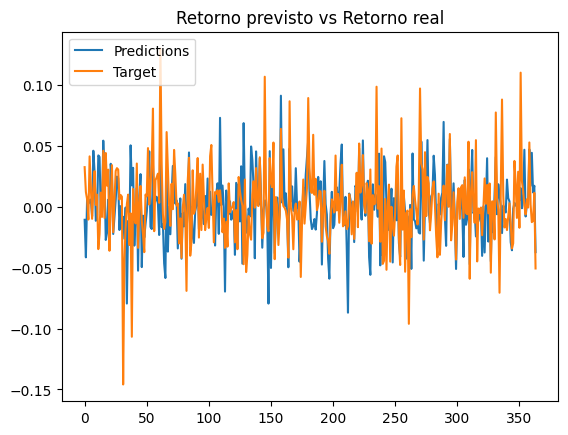

% Acerto de tendencia: 0.6703296703296703


In [2]:
from data_analysis.services.random_forests import RandomForestsWrapper
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

np.random.seed(31415) 

instance = RandomForestsWrapper()
results = RandomForestsWrapper().run(petr4_1_days, 'Close PnL 1 days')
predictions = results['predictions']
errors = results['errors']
test_target = results['test_target']

print('Mean Absolute Error:', round(np.mean(errors), 2))
print('Mean Absolute Error / Média', round(np.mean(errors)/np.mean(test_target), 2))
# Predicting the target values of the test set

# RMSE (Root Mean Square Error)
rmse = float(format(np.sqrt(mean_squared_error(test_target, predictions)), '.3f'))
print("\nRMSE: ", rmse)

print("Média do resultado financeiro:", round(np.mean(test_target), 5))
# print("RMSE/Média", round(rmse/np.mean(test_target), 5))


plt.plot(predictions, label='Predictions')
plt.plot(test_target, label='Target')
plt.legend(loc="upper left")
plt.title('Retorno previsto vs Retorno real')
plt.show()

direction_count = 0
for index in range(len(predictions)):
    if predictions[index] > 0 and test_target[index] > 0:
        direction_count += 1
    if predictions[index] < 0 and test_target[index] < 0:
        direction_count += 1

print(f'% Acerto de tendencia: {direction_count/len(predictions)}')

Mean Absolute Error: 0.03
Mean Absolute Error / Média 4.37

RMSE:  0.046
Média do resultado financeiro: 0.0076


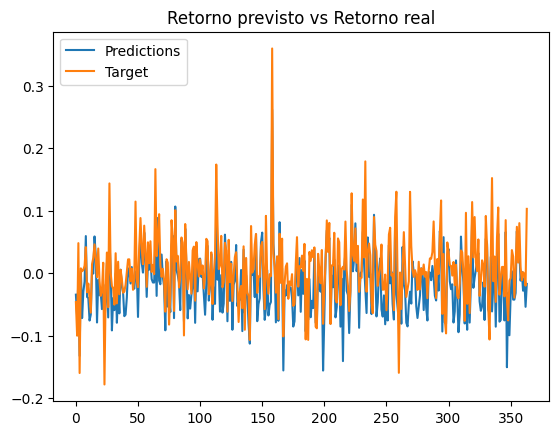

% Acerto de tendencia: 0.739010989010989


In [3]:
from data_analysis.services.random_forests import RandomForestsWrapper
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

np.random.seed(31415) 

instance = RandomForestsWrapper()
results = RandomForestsWrapper().run(petr4_3_days, 'Close PnL 3 days')
predictions = results['predictions']
errors = results['errors']
test_target = results['test_target']

print('Mean Absolute Error:', round(np.mean(errors), 2))
print('Mean Absolute Error / Média', round(np.mean(errors)/np.mean(test_target), 2))
# Predicting the target values of the test set

# RMSE (Root Mean Square Error)
rmse = float(format(np.sqrt(mean_squared_error(test_target, predictions)), '.3f'))
print("\nRMSE: ", rmse)

print("Média do resultado financeiro:", round(np.mean(test_target), 5))
# print("RMSE/Média", round(rmse/np.mean(test_target), 5))


plt.plot(predictions, label='Predictions')
plt.plot(test_target, label='Target')
plt.legend(loc="upper left")
plt.title('Retorno previsto vs Retorno real')
plt.show()

direction_count = 0
for index in range(len(predictions)):
    if predictions[index] > 0 and test_target[index] > 0:
        direction_count += 1
    if predictions[index] < 0 and test_target[index] < 0:
        direction_count += 1

print(f'% Acerto de tendencia: {direction_count/len(predictions)}')

In [1]:
from data_analysis.services.random_forests import RandomForestsWrapper
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

np.random.seed(31415) 

instance = RandomForestsWrapper()
results = RandomForestsWrapper().run(petr4_5_days, 'Close PnL 5 days')
predictions = results['predictions']
errors = results['errors']
test_target = results['test_target']

print('Mean Absolute Error:', round(np.mean(errors), 2))
print('Mean Absolute Error / Média', round(np.mean(errors)/np.mean(test_target), 2))
# Predicting the target values of the test set

# RMSE (Root Mean Square Error)
rmse = float(format(np.sqrt(mean_squared_error(test_target, predictions)), '.3f'))
print("\nRMSE: ", rmse)

print("Média do resultado financeiro:", round(np.mean(test_target), 5))
# print("RMSE/Média", round(rmse/np.mean(test_target), 5))


plt.plot(predictions, label='Predictions')
plt.plot(test_target, label='Target')
plt.legend(loc="upper left")
plt.title('Retorno previsto vs Retorno real')
plt.show()

direction_count = 0
for index in range(len(predictions)):
    if predictions[index] > 0 and test_target[index] > 0:
        direction_count += 1
    if predictions[index] < 0 and test_target[index] < 0:
        direction_count += 1

print(f'% Acerto de tendencia: {direction_count/len(predictions)}')

ModuleNotFoundError: No module named 'data_analysis'

**TESTES COM OTIMIZAÇÃO DE PORTFÓLIO**

In [22]:
import sys, os
sys.path.append(os.path.abspath("."))
sys.path.append(os.path.abspath(".."))
from portfolio_management.services.markowitz_optimizator import MarkowitzOptimizator
from portfolio_management.services.equal_weights_optimizator import EqualWeightsOptimizator
from portfolio_management.services.balanced_weights_optimizator import BalancedWeightsOptimizator
from data_analysis.services import RandomForestsWrapper, StockPreprocessor
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
stocks = [
    'PETR4.SA',
    'WEGE3.SA', 
    'ITUB4.SA', 
    'VALE3.SA', 
    'B3SA3.SA', 
    'BEEF3.SA',
    ## 'BPAC11.SA',
    'CYRE3.SA',
    'ELET3.SA',
    'FLRY3.SA',
    'MGLU3.SA',
    ## 'VIIA3.SA',
    'KLBN11.SA',
    'RENT3.SA',
    ## 'RAIL3.SA'
    ]
price_column = 'Close'
df_list = []
price_dfs = []
target_dfs = []
start_date = '2015-01-01'
end_date = '2020-01-01'

# start_pred = '2020-01-01'
# year,month,day = start_pred.split('-')
# start_pred_date = date(int(year), int(month), int(day))
# year,month,day = end_date.split('-')
# end_pred_date = date(int(year), int(month), int(day))
# start_pred_end = end_pred_date - start_pred_date
# division = start_pred_end.days / 0.3
# start_date = end_pred_date - timedelta(days = division)

periods = 5
target_column = f'{price_column} PnL {periods} days'
desired_risk = 500
initial_investment = 1

for stock in stocks:
    preprocessed_stock = StockPreprocessor.preprocess(
        stock,
        start_date,
        price_column,
        periods,
        end_date
    )
    predicted_stock = RandomForestsWrapper().run(preprocessed_stock, target_column, price_column)
    predictions = predicted_stock['predictions']
    test_target = predicted_stock['test_target']

    data = {'Predictions': predictions, 'Actual': test_target}
    direction_count = 0
    for index in range(len(predictions)):
        if predictions[index] > 0 and test_target[index] > 0:
            direction_count += 1
        if predictions[index] < 0 and test_target[index] < 0:
            direction_count += 1
            
    print(f'% Acerto de tendencia {stock}: {direction_count/len(predictions)}')
    actual_vs_predicted_df = pd.DataFrame(data)
    df_list.append(actual_vs_predicted_df)
    price_dfs.append(predicted_stock['price_data'])
    target_dfs.append(predicted_stock['target_data'])
    start_test_date = predicted_stock['start_test_date']
    end_test_date = datetime.strptime(end_date, '%Y-%m-%d')
    # print(f'{stock} final std')
    # print(np.sqrt(np.array(predicted_stock['price_data'].var() * 252)[0]))

% Acerto de tendencia PETR4.SA: 0.8126721763085399
% Acerto de tendencia WEGE3.SA: 0.7961432506887053
% Acerto de tendencia ITUB4.SA: 0.7713498622589532
% Acerto de tendencia VALE3.SA: 0.5922865013774105
% Acerto de tendencia B3SA3.SA: 0.8016528925619835
% Acerto de tendencia BEEF3.SA: 0.7933884297520661
% Acerto de tendencia CYRE3.SA: 0.8099173553719008
% Acerto de tendencia ELET3.SA: 0.7520661157024794
% Acerto de tendencia FLRY3.SA: 0.7988980716253443
% Acerto de tendencia MGLU3.SA: 0.8236914600550964
% Acerto de tendencia KLBN11.SA: 0.8539944903581267
% Acerto de tendencia RENT3.SA: 0.8236914600550964


In [23]:
equal_weights_no_sentiment = EqualWeightsOptimizator().optimize(
    price_dfs=price_dfs,
    dfs=df_list, 
    tickers=stocks, 
    price_column=price_column,
    periods=periods,
    initial_investment=initial_investment
)
markowitz_no_sentiment = MarkowitzOptimizator().optimize(
    price_dfs=price_dfs,
    dfs=df_list, 
    tickers=stocks, 
    price_column=price_column,
    desired_risk=desired_risk,
    periods=periods,
    initial_investment=initial_investment
)
balanced_weights_no_sentiment = BalancedWeightsOptimizator().optimize(
    price_dfs=price_dfs,
    dfs=df_list, 
    tickers=stocks, 
    price_column=price_column,
    periods=periods,
    initial_investment=initial_investment
)

In [3]:
from portfolio_management.services.benchmark import BenchmarkComparator
from data_analysis.useful_defaults import IBOVESPA, CDI, SP500
benchmark_name = IBOVESPA['bench_name']
benchmark_type = IBOVESPA['bench']
column = IBOVESPA['column']
date_column = IBOVESPA['date_column']
benchmark_ticker = IBOVESPA['ticker']
initial_investment = 1
benchmark = BenchmarkComparator().get_benchmark_data(
    start_test_date, 
    end_test_date, 
    benchmark_type, 
    initial_investment, 
    column, 
    benchmark_ticker)

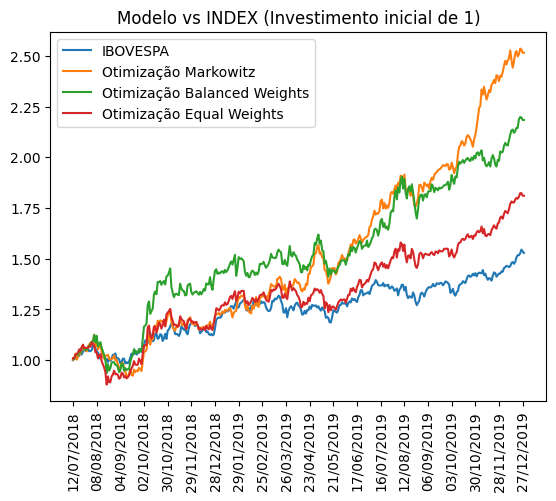

In [4]:
import matplotlib.pyplot as plt
tick_divider = 5
plt.plot(benchmark['capitalization'], label=benchmark_name)
plt.plot(markowitz_no_sentiment['capitalization'], label='Otimização Markowitz')
plt.plot(balanced_weights_no_sentiment['capitalization'], label='Otimização Balanced Weights')
plt.plot(equal_weights_no_sentiment['capitalization'], label='Otimização Equal Weights')
plt.legend(loc="upper left")
plt.title(f'Modelo vs {benchmark_type} (Investimento inicial de {initial_investment})')
plt.xticks(ticks = range(0,len(benchmark.index)), labels = benchmark[date_column], rotation='vertical')
plt.locator_params(axis='x', nbins=20)
plt.show()


**TESTES COM SENTIMENTO**

In [24]:
import sys, os
sys.path.append(os.path.abspath("."))
sys.path.append(os.path.abspath(".."))
from data_analysis.services.sentiment_analyzer import SentimentAnalyzer
from portfolio_management.services.markowitz_optimizator import MarkowitzOptimizator
from portfolio_management.services.equal_weights_optimizator import EqualWeightsOptimizator
from portfolio_management.services.balanced_weights_optimizator import BalancedWeightsOptimizator
from data_analysis.services import RandomForestsWrapper, StockPreprocessor
import pandas as pd
from datetime import datetime

stocks = [
    'PETR4.SA',
    'WEGE3.SA', 
    'ITUB4.SA', 
    'VALE3.SA', 
    'B3SA3.SA', 
    'BEEF3.SA',
    ## 'BPAC11.SA',
    'CYRE3.SA',
    'ELET3.SA',
    'FLRY3.SA',
    'MGLU3.SA',
    ## 'VIIA3.SA',
    'KLBN11.SA',
    'RENT3.SA',
    ## 'RAIL3.SA'
    ]

query = {'kagglenews_id__category': 'BUSINESS'}
analyzer = SentimentAnalyzer()

price_column = 'Close'
df_list = []
price_dfs = []
target_dfs = []
start_date = '2015-01-01'
end_date = '2020-01-01'
stock = 'PETR4.SA'

# start_pred = '2020-01-01'
# year,month,day = start_pred.split('-')
# start_pred_date = date(int(year), int(month), int(day))
# year,month,day = end_date.split('-')
# end_pred_date = date(int(year), int(month), int(day))
# start_pred_end = end_pred_date - start_pred_date
# division = start_pred_end.days / 0.3
# start_date = end_pred_date - timedelta(days = division)

periods = 5
target_column = f'{price_column} PnL {periods} days'
desired_risk = 500
initial_investment = 1
first_run = True
for stock in stocks:
    try:
        preprocessed_stock = pd.read_csv(f'{stock}_{start_date}_{end_date}_sentiment.csv', index_col='Date')
    except:
        preprocessed_stock = StockPreprocessor.preprocess(
            stock,
            start_date,
            price_column,
            periods,
            end_date
        )
        if first_run:
            _foo = preprocessed_stock.index.to_series().apply(analyzer.analyze, query=query, periods=periods)
            first_run = False
            
        preprocessed_stock['very_negative_ratio'] = analyzer.vneg_ratio_list
        preprocessed_stock['negative_ratio'] = analyzer.neg_ratio_list
        preprocessed_stock['neutral_ratio'] = analyzer.neutral_ratio_list
        preprocessed_stock['positive_ratio'] = analyzer.pos_ratio_list
        preprocessed_stock['very_positive_ratio'] = analyzer.vpos_ratio_list
        
        preprocessed_stock.to_csv(f'{stock}_{start_date}_{end_date}_sentiment.csv')
    
    predicted_stock = RandomForestsWrapper().run(preprocessed_stock, target_column, price_column)
    predictions = predicted_stock['predictions']
    test_target = predicted_stock['test_target']

    data = {'Predictions': predictions, 'Actual': test_target}
    direction_count = 0
    for index in range(len(predictions)):
        if predictions[index] > 0 and test_target[index] > 0:
            direction_count += 1
        if predictions[index] < 0 and test_target[index] < 0:
            direction_count += 1
            
    print(f'% Acerto de tendencia {stock}: {direction_count/len(predictions)}')
    actual_vs_predicted_df = pd.DataFrame(data)
    df_list.append(actual_vs_predicted_df)
    price_dfs.append(predicted_stock['price_data'])
    target_dfs.append(predicted_stock['target_data'])
    start_test_date = predicted_stock['start_test_date']
    end_test_date = datetime.strptime(end_date, '%Y-%m-%d')

% Acerto de tendencia PETR4.SA: 0.8044077134986226
% Acerto de tendencia WEGE3.SA: 0.790633608815427
% Acerto de tendencia ITUB4.SA: 0.7630853994490359
% Acerto de tendencia VALE3.SA: 0.5977961432506887
% Acerto de tendencia B3SA3.SA: 0.8099173553719008
% Acerto de tendencia BEEF3.SA: 0.8071625344352618
% Acerto de tendencia CYRE3.SA: 0.8181818181818182
% Acerto de tendencia ELET3.SA: 0.7520661157024794
% Acerto de tendencia FLRY3.SA: 0.8126721763085399
% Acerto de tendencia MGLU3.SA: 0.8209366391184573
% Acerto de tendencia KLBN11.SA: 0.8622589531680441
% Acerto de tendencia RENT3.SA: 0.8126721763085399


In [25]:
equal_weights_with_sentiment = EqualWeightsOptimizator().optimize(
    price_dfs=price_dfs,
    dfs=df_list, 
    tickers=stocks, 
    price_column=price_column,
    periods=periods,
    initial_investment=initial_investment
)
markowitz_with_sentiment = MarkowitzOptimizator().optimize(
    price_dfs=price_dfs,
    dfs=df_list, 
    tickers=stocks, 
    price_column=price_column,
    desired_risk=desired_risk,
    periods=periods,
    initial_investment=initial_investment
)
balanced_weights_with_sentiment = BalancedWeightsOptimizator().optimize(
    price_dfs=price_dfs,
    dfs=df_list, 
    tickers=stocks, 
    price_column=price_column,
    periods=periods,
    initial_investment=initial_investment
)

In [26]:
from portfolio_management.services.benchmark import BenchmarkComparator
from data_analysis.useful_defaults import IBOVESPA, CDI, SP500
benchmark_name = IBOVESPA['bench_name']
benchmark_type = IBOVESPA['bench']
column = IBOVESPA['column']
date_column = IBOVESPA['date_column']
benchmark_ticker = IBOVESPA['ticker']
initial_investment = 1
benchmark = BenchmarkComparator().get_benchmark_data(
    start_test_date, 
    end_test_date, 
    benchmark_type, 
    initial_investment, 
    column, 
    benchmark_ticker)

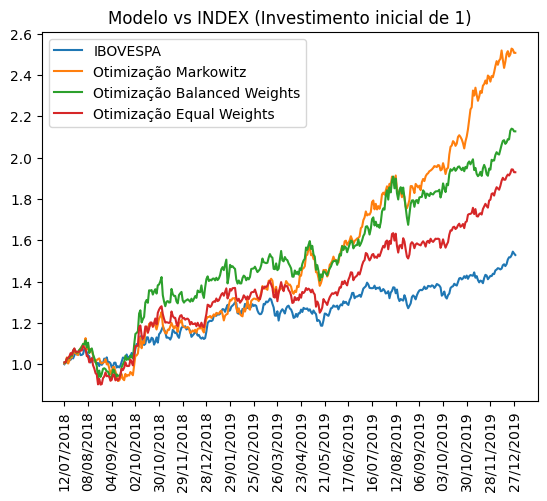

In [27]:
import matplotlib.pyplot as plt
tick_divider = 5
plt.plot(benchmark['capitalization'], label=benchmark_name)
plt.plot(markowitz_with_sentiment['capitalization'], label='Otimização Markowitz')
plt.plot(balanced_weights_with_sentiment['capitalization'], label='Otimização Balanced Weights')
plt.plot(equal_weights_with_sentiment['capitalization'], label='Otimização Equal Weights')
plt.legend(loc="upper left")
plt.title(f'Modelo vs {benchmark_type} (Investimento inicial de {initial_investment})')
plt.xticks(ticks = range(0,len(benchmark.index)), labels = benchmark[date_column], rotation='vertical')
plt.locator_params(axis='x', nbins=20)
plt.show()

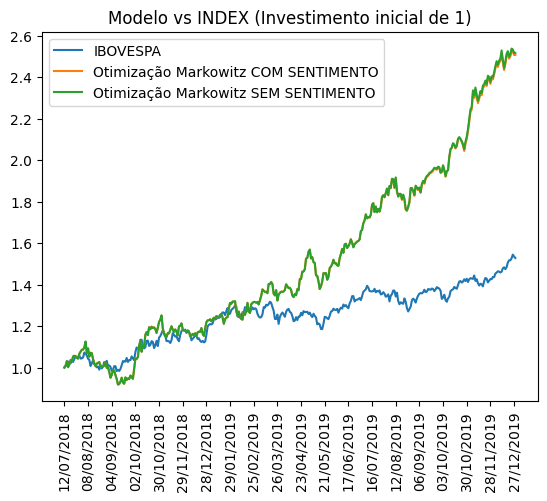

In [28]:
import matplotlib.pyplot as plt
tick_divider = 5
plt.plot(benchmark['capitalization'], label=benchmark_name)
plt.plot(markowitz_with_sentiment['capitalization'], label='Otimização Markowitz COM SENTIMENTO')
plt.plot(markowitz_no_sentiment['capitalization'], label='Otimização Markowitz SEM SENTIMENTO')
plt.legend(loc="upper left")
plt.title(f'Modelo vs {benchmark_type} (Investimento inicial de {initial_investment})')
plt.xticks(ticks = range(0,len(benchmark.index)), labels = benchmark[date_column], rotation='vertical')
plt.locator_params(axis='x', nbins=20)
plt.show()